In [4]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.pure_fit_model as pure_fit_model

import torch
from tqdm import tqdm
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
def sim(timeHorizon, model: pure_fit_model.pure_EPI_dense, state):
  populationNumber= []
  states = [state]
  for _ in range(timeHorizon):
    state= model(state)
    populationNumber.append(model.get_population_num(state))
    states.append(torch.clone(state))
  populationNumber = torch.stack(populationNumber)
  states = torch.stack(states)
  return populationNumber, states

In [7]:
n= 1000
avgDegree= 4
timeHorizon= 130
print("haha")
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
print("haha")
contact = contact.requires_grad_(True)
ps=     torch.tensor([[0, 0.2, 0, 0],
                      [0, 0, 0.4, 0],
                      [0, 0, 0, 0.05],
                      [0, 0, 0, 0]], device=device)
state= create_population.population(n, device)
model=pure_fit_model.pure_EPI_dense(contact, ps, device=device, sampleAsState= False)
with torch.no_grad():
    realData, _= sim(timeHorizon, model=model, state=state)
    realData= realData.squeeze()

haha
haha
torch.Size([1, 4, 1000])


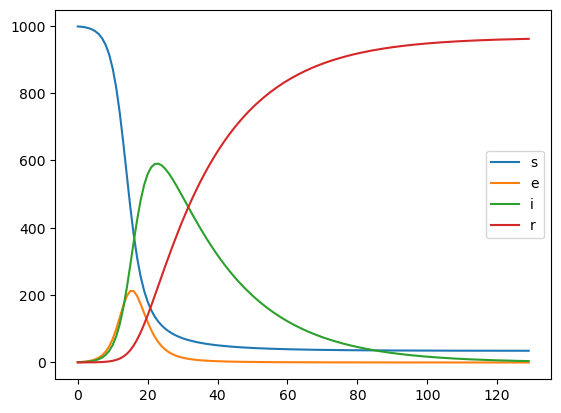

In [8]:
plotRealNumber= realData.cpu().detach()
plt.plot(plotRealNumber, label=["s", "e", "i", "r"])
plt.legend()

In [13]:
windowSize= 5
batchSize= 40
realData.requires_grad_(True)
psFit= torch.zeros([4, 4], device=device)
cc= torch.tensor([[0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0]], device=device)
modelFit= pure_fit_model.pure_EPI_dense(contact, psFit, device=device, cc=cc, train=True, sampleAsState=False)
lossFn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(modelFit.parameters(), lr=1e-2)
#generate dataset
def generate_dateset(model: pure_fit_model.pure_EPI_dense, ys, timeHorizon=100, windowSize= 5):
    with torch.no_grad():
        stateZero = create_population.population(n, device)
        _, states= sim(timeHorizon-windowSize-1, model, stateZero)#generate data more times?
        states= states.squeeze()
        infectiveNum=[]
        for i in range(timeHorizon-windowSize):
            infectiveNum.append(ys[i: i+windowSize])
        infectiveNum= torch.stack(infectiveNum)
        dataset = torch.utils.data.TensorDataset(states, infectiveNum)
        return dataset, states
losses= []

In [14]:

for i in tqdm(range(400)):
    dataset, states= generate_dateset(modelFit, realData[ :, 2], timeHorizon, windowSize= windowSize)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle = True)
    #with torch.autograd.set_detect_anomaly(True):
    for batch in dataloader:
        optimizer.zero_grad()
        fitY= []
        x, y = batch
        x=[x]
        for j in range(windowSize):
            out= modelFit(x[-1])
            fitY.append(model.get_population_num(out))
            x.append(out)
        y= y.T
        fitY= torch.stack(fitY)
        loss= lossFn(fitY[:, :, 2], y)/n/windowSize
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        break
        

100%|██████████| 400/400 [02:47<00:00,  2.39it/s]


torch.Size([125, 4, 1000])
tensor([[0.7393, 0.2607, 0.0000, 0.0000],
        [0.0000, 0.6926, 0.3074, 0.0000],
        [0.0000, 0.0000, 0.9492, 0.0508],
        [0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([125, 4])


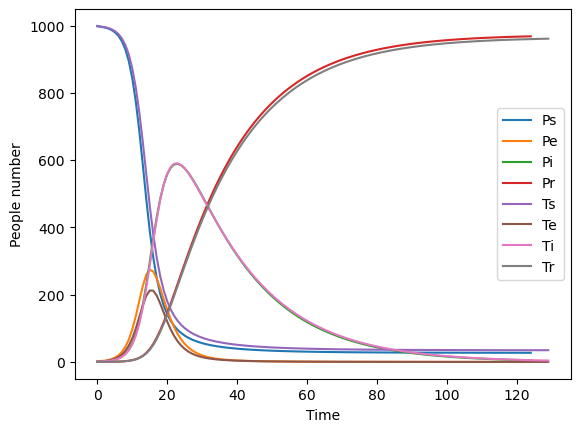

In [15]:
plotSatte= states.cpu().detach()
print(plotSatte.shape)
print(modelFit.get_psMatrix())
plotSatte= plotSatte.sum(dim=2)
print(plotSatte.shape)
plt.plot(plotSatte, label=["Ps", "Pe", "Pi", "Pr"])
plt.plot(plotRealNumber, label=["Ts", "Te", "Ti", "Tr"])
plt.xlabel("Time")
plt.ylabel("People number")
plt.legend()

Text(0.5, 0, 'Epoches')

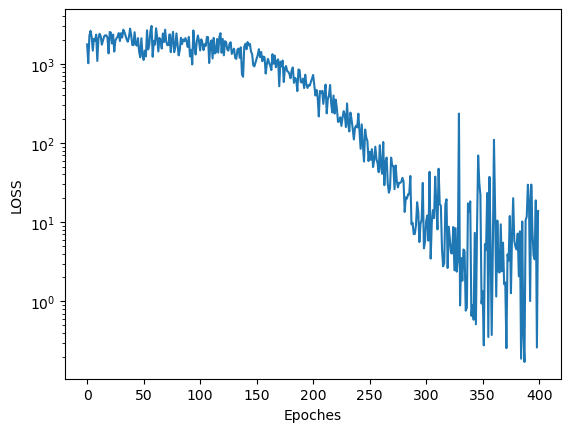

In [16]:
plt.plot(losses)
plt.yscale("log")
plt.ylabel("LOSS")
plt.xlabel("Epoches")

In [50]:
def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[ 0.0000, -0.9074,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.8754,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -2.9178],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[ 0.0000e+00, -6.0447e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.3739e+01,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.3755e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0')
---------------------------------
